# Mini Project: Predictive Maintenance using Machine Learning # 

Project Description: 
In this mini project, you will develop a predictive maintenance system using machine
learning techniques. The goal is to predict machine failures based on sensor data from
industrial equipment. You will work with a dataset containing various sensor measurements
and use two different machine learning models of your choice 

Dataset: 
You will use the "AI4I 2020 Predictive Maintenance Dataset" from the UCI Machine Learning
Repository.
https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset 

The dataset includes the following features:
• Air temperature [K]
• Process temperature [K]
• Rotational speed [rpm]
• Torque [Nm]
• Tool wear [min]

The target variable is 'Machine failure' (0 for no failure, 1 for failure).


Deliverables:
• A Jupyter notebook containing all the code, visualizations, and explanations for each
task (each group submits one)
• A brief summarization your approach, key findings, and recommendations in final
report as part two.

Evaluation Criteria:
- Correctness and completeness of the implemented tasks
- Quality of code and adherence to best practices
- Depth of analysis and insights derived from the data and models
- Clarity of explanations and visualizations
- Criteria of model selection, model improvement strategies
- Justification for choices made throughout the project

# Pipline #

Pipeline: Define the problem -> Gather data -> Explore data -> Prepare data -> Explore models -> Fine-tune model -> Evaluation solutions -> Deploy solution. 

The step deploy solution will not be implemented.


# Define the problem: #
 Predict 'Machine failure' (0 for no failure, 1 for failure)

In [63]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import requests
from io import StringIO
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier 

# Gather data: #

In [64]:
# Load the dataset
df = pd.read_csv('ai4i2020.csv')

# Display the first few rows of the dataframe
df.head() 


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


Given that the data is clearly labeled there will be a look into supervised learning.

# Explore data: # 

How to read headers for data:
- UDI = Unique Data Identifier,
- TWF = Tool wear failure, 
- HDF = Heat Dissipation Failure,
- PWF = Power Failure,
- OSF = Overstrain Failure,
- RNF = Random Failure

In [65]:
#How many samples and features are in the dataset
print(df.shape) 

(10000, 14)


In [66]:
#How many types are there (M, L, H)
type_counts = df['Type'].value_counts()
print(type_counts)

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64


In [67]:
# Find points with failure
machine_failure_points = df[df['Machine failure'] == 1]
print(machine_failure_points)

       UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
50      51     L47230    L                298.9                    309.1   
69      70     L47249    L                298.9                    309.0   
77      78     L47257    L                298.8                    308.9   
160    161     L47340    L                298.4                    308.2   
161    162     L47341    L                298.3                    308.1   
...    ...        ...  ...                  ...                      ...   
9758  9759     L56938    L                298.6                    309.8   
9764  9765     L56944    L                298.5                    309.5   
9822  9823     L57002    L                298.5                    309.4   
9830  9831     L57010    L                298.3                    309.3   
9974  9975     L57154    L                298.6                    308.2   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  \
50      

In [68]:
#How many points are there with failure (1) and without failure (0)
failure_counts = df['Machine failure'].value_counts()
print(failure_counts) 

Machine failure
0    9661
1     339
Name: count, dtype: int64


This means that 96.6% of the data does not predict failure. Thus, there is a majority class of 0.

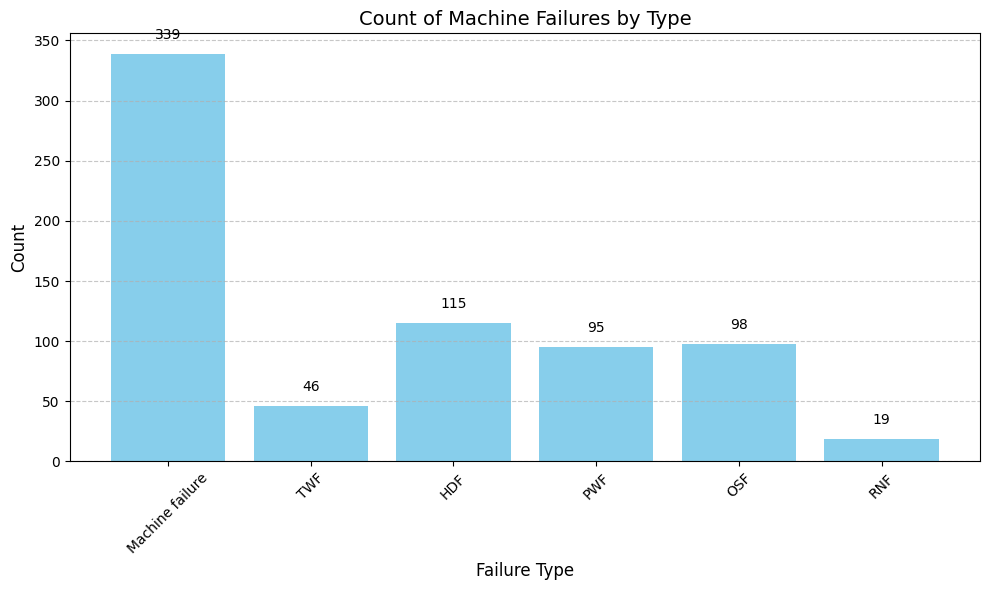

Machine failure    339
TWF                 46
HDF                115
PWF                 95
OSF                 98
RNF                 19
dtype: int64


In [69]:
# Count machine failures and individual failure types
failure_counts = df[['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum()

# Plot the counts as a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(failure_counts.index, failure_counts.values, color='skyblue')

# Add text annotations to display the count above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom')

plt.title('Count of Machine Failures by Type', fontsize=14)
plt.xlabel('Failure Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the chart
plt.show()

# Print the counts for reference
print(failure_counts)



      TWF  HDF  PWF  OSF  RNF
Type                         
H       7    8    5    2    4
L      25   76   59   87   13
M      14   31   31    9    2


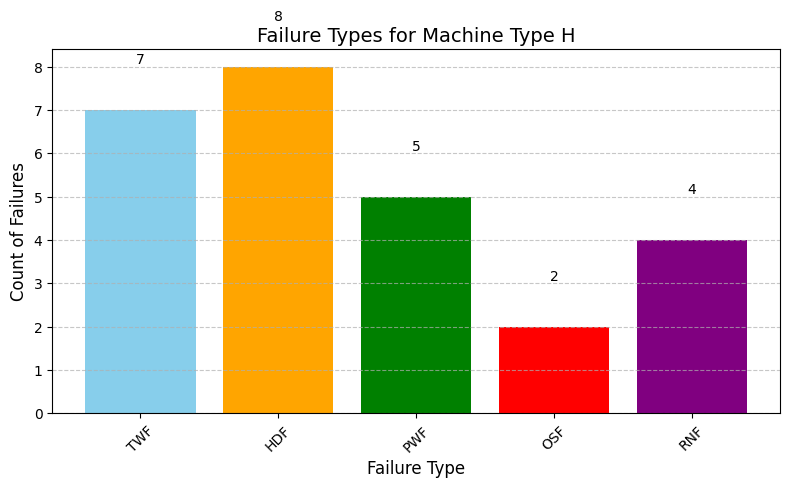

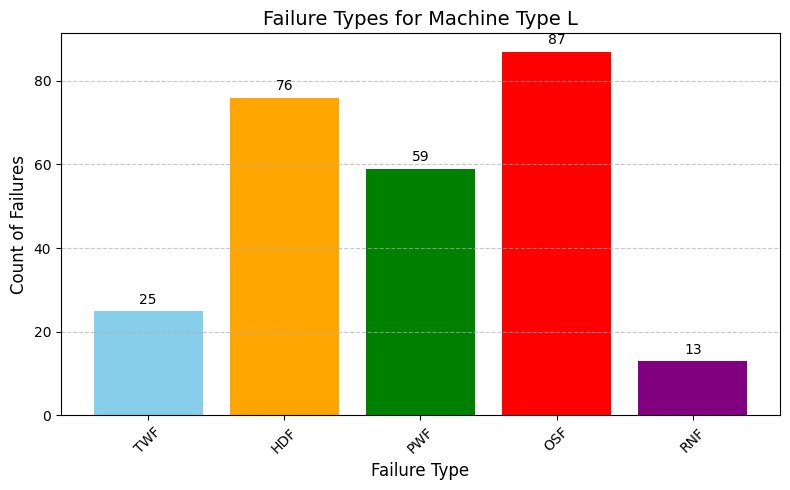

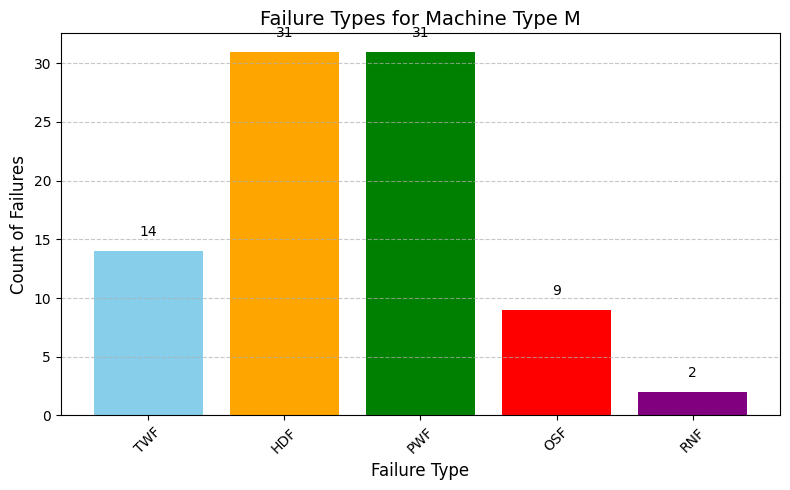

In [70]:
# Show failure types for the diffrent types
 
# Group by 'Type' and sum the failure types
failure_types_by_type = df.groupby('Type')[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum()

# Print the failure types by machine type for reference
print(failure_types_by_type)

# Plot failure types for each machine type separately
machine_types = failure_types_by_type.index

for machine_type in machine_types:
    failure_counts = failure_types_by_type.loc[machine_type]
    
    plt.figure(figsize=(8, 5))
    bars = plt.bar(failure_counts.index, failure_counts.values, color=['skyblue', 'orange', 'green', 'red', 'purple'])
    
    # Add text annotations to display the count above each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')
    
    plt.title(f'Failure Types for Machine Type {machine_type}', fontsize=14)
    plt.xlabel('Failure Type', fontsize=12)
    plt.ylabel('Count of Failures', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Display the chart
    plt.show()

In [71]:
# show the number of failure in porcentage for each type compared to the total number of failure for the type.
# Calculate the total number of failures for each type
total_failures_by_type = failure_types_by_type.sum(axis=1)


# Calculate the total number of failures for all machine types
total_failures_all_types = failure_types_by_type.sum().sum()

# Calculate the percentage of failures for each machine type
percentage_failures_all_types = (total_failures_by_type / total_failures_all_types) * 100

# Output 
print(percentage_failures_all_types)
print(total_failures_by_type)


Type
H     6.970509
L    69.705094
M    23.324397
dtype: float64
Type
H     26
L    260
M     87
dtype: int64


In [72]:
#How many procent of machines fail and how many procent of each type fail
# Calculate the percentage of machines that fail
total_machines = len(df)
total_failures = df['Machine failure'].sum()
percentage_failures = (total_failures / total_machines) * 100

# Calculate the percentage of failures for each type
failure_counts_by_type = df.groupby('Type')['Machine failure'].sum()
total_samples_by_type = df['Type'].value_counts()
percentage_failures_by_type = (failure_counts_by_type / total_samples_by_type) * 100

# Output the percentages
print(f"Percentage of machines that fail: {percentage_failures:.2f}%")
print("Percentage of failures by machine type:")
print(percentage_failures_by_type) 

Percentage of machines that fail: 3.39%
Percentage of failures by machine type:
Type
H    2.093719
L    3.916667
M    2.769436
dtype: float64


There are 3 types of machines but for this mini project, that fact will be neglected. This is due to the data set being relatively small.

# Prepare data: #

In [73]:
#Check if there is NaN (cleaning the data)
df.isnull().sum() 

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

There are no NaN

In [74]:
# Separate features (X) and target variable (y). Here our target variable is 'Machine failure'
X = df.drop(columns=['Machine failure', 'UDI', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Type', 'Product ID'])
y = df['Machine failure'] 

In [75]:
# Split the data, a typical split ratio is 60% training, 20% validation and 20% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# the random_state parameter is used to ensure that the data is split in the same way each time the code is run.

In [76]:
# Scale the features
scaler = StandardScaler()
numeric_columns = ['Air temperature [K]', 'Process temperature [K]', 
				   'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_val_scaled = scaler.transform(X_val[numeric_columns])
X_test_scaled = scaler.transform(X_test[numeric_columns])


# Explore models #

The goal is to predict no failure (0) or failure (1), this is thus yes/no.  
Models that can be used for this are Logistic Regression, Support Vector Machines,  random forest, etc.

The chosen models are her Logistic regression and Random Forest. Here SVM is not chosen due to the spread of the points if a pair plot is made.


#Create a pair plot of the features
sns.pairplot(df, hue='Machine failure', vars=numeric_columns, palette='coolwarm')
plt.suptitle('Pair Plot of Features with Machine Failure', y=1.02)
plt.show()

# Logistic regression # 

# Fine-tune model  # 

In [77]:
# Create and train the logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

print("Model training and prediction completed.")

Model training and prediction completed.


## Model Evaluation

Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1932
           1       0.90      0.13      0.23        68

    accuracy                           0.97      2000
   macro avg       0.94      0.57      0.61      2000
weighted avg       0.97      0.97      0.96      2000



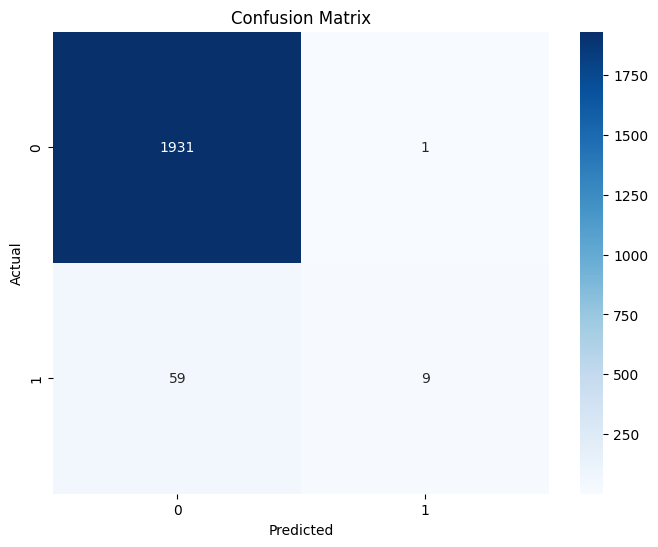

In [78]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Model interpretation #

Before concluding on the model coefficients will be analyzed.   

Model Coefficients:
                   Feature  Coefficient
3              Torque [Nm]     2.583739
2   Rotational speed [rpm]     1.842077
0      Air temperature [K]     1.425278
1  Process temperature [K]    -0.959741
4          Tool wear [min]     0.774136


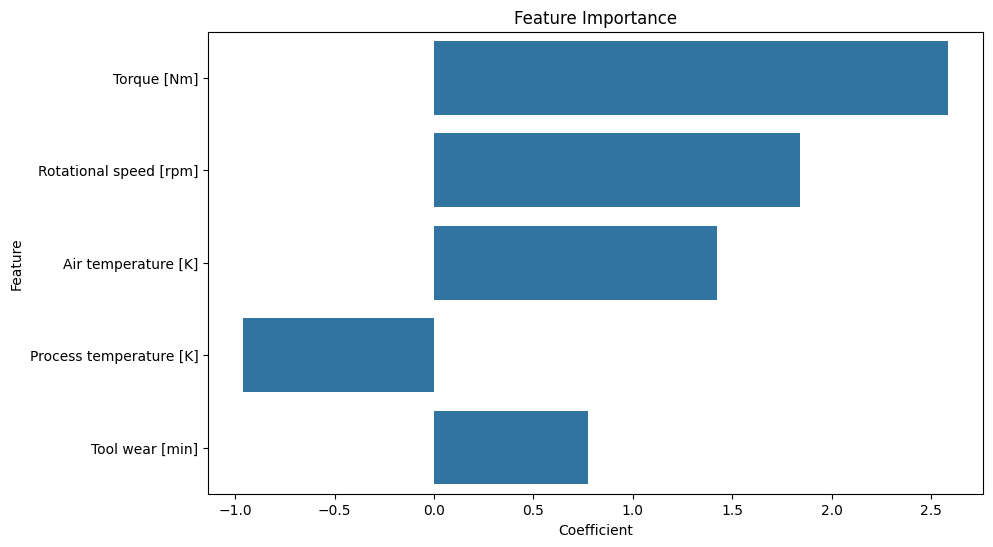

In [79]:
# Print coefficients
coefficients = pd.DataFrame({'Feature': numeric_columns, 'Coefficient': model.coef_[0]})
coefficients = coefficients.sort_values(by='Coefficient', key=abs, ascending=False)
print("Model Coefficients:")
print(coefficients)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Feature Importance')
plt.show()

# Sub conclusion # 

1. Model performance: 

The model performed well in predicting nonfailure (0) which is the majority class and is what the data set is 97% consisting of.
Thus by simply predicting 0 all the time one may get 97% of the samples correct. 
The minority class (1) or failure is underrepresented at 3% of the sample set. Here the logistic regression model has a recall for this at 0.13 meaning that it fails to predict 87% of the actual class 1 instances. This is unacceptable given that it is better to over-predict class 1 than not.


2. Important features: 

It can be seen that the most important features, to predict failure are: Torque, Rotational speed, and air temperature. Here Process temperature is seen to have a negative correlation

3. Limitations: 

 - The data set is relatively small at 10,000 samples and the number of class 1 samples, at 339, is very small
 - The data consists of a huge majority class 0 and a very small minority class 1
 - Linear relationship between features and log-odds. Elaboration: Linear regression predicts log odds of the outcome. The odds are a ratio of the probability of the outcome happening (P) to the probability of it not happening. Odds = P/(1-P). Here a linear relation is assumed between input features and the log odds of the outcome theses are modeled as ln(P/(1-P)) = B_0+B_1x_1+B_2x_2+...+B_kx_k.. The probability transformation is then done via the sigmoid sig(t) = 1/(1-exp(-t)).


4. Potential improvements: 

- Balancing the dataset e.g. oversampling failure, class 1, or under sampling non failure, class 0,
- Class weighting: assign different weights to the two classes 
- Split the data set up into the 3 different machine types (M, L, H)
- Try nonlinear models or models with focus on minority class detection e.g. random forest 
- Feature engineering or selection 
- Cross-validation 
- Collet more data


# Choice of new parameters for Logistic regression model #

Based on the sub conclusion it is desired to redo the model with: 
1. Feature engineering: Remove process temperature due to it having a negative correlation
2. Balanced the datasheet: The number of class 0 and class 1 samples will be set to the same via oversampling / up sample.
(Here understanding is avoided due to the limited number of classes 1)


In [80]:
# Combine X and y into a single dataframe for resampling
df_combined = pd.concat([X, y], axis=1)

# Separate majority and minority classes
df_majority = df_combined[df_combined['Machine failure'] == 0]
df_minority = df_combined[df_combined['Machine failure'] == 1]

# Upsample minority class (duplicated to match the number of samples in the majority class)
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Separate features and target variable
# Check which columns are present in the dataframe
columns_to_drop = [col for col in ['UDI', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Type', 'Product ID', 'Process temperature [K]'] if col in df_upsampled.columns]
features_to_drop = ['Machine failure'] + columns_to_drop
X1 = df_upsampled.drop(columns=features_to_drop)
y1 = df_upsampled['Machine failure']

# Scale the features
scaler = StandardScaler()
X1_balanced_scaled = scaler.fit_transform(X1)

# Split the data into training, validation, and test sets
X1_train_balanced, X1_temp_balanced, y1_train_balanced, y1_temp_balanced = train_test_split(X1_balanced_scaled, y1, test_size=0.4, random_state=42)
X1_val_balanced, X1_test_balanced, y1_val_balanced, y1_test_balanced = train_test_split(X1_temp_balanced, y1_temp_balanced, test_size=0.5, random_state=42)

print("Feature scaling and balancing completed.")


Feature scaling and balancing completed.


In [81]:
# Create and train the logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X1_train_balanced, y1_train_balanced)

# Make predictions
y_pred = model.predict(X1_test_balanced)

print("Model training and prediction completed.")

Model training and prediction completed.


Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1969
           1       0.80      0.79      0.79      1896

    accuracy                           0.80      3865
   macro avg       0.80      0.80      0.80      3865
weighted avg       0.80      0.80      0.80      3865



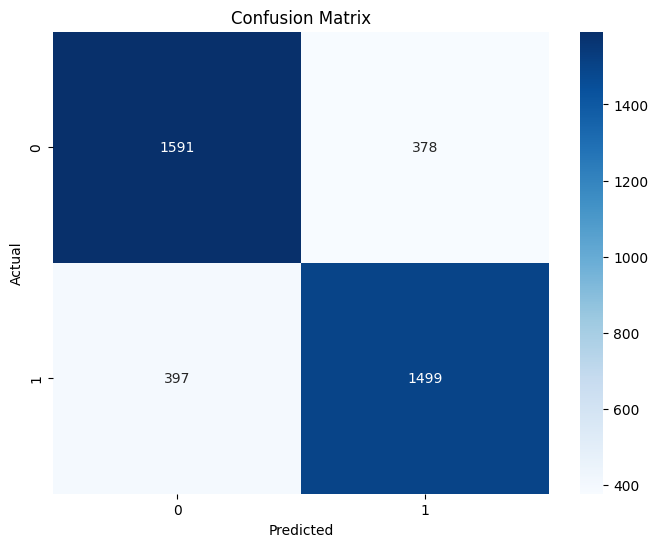

In [82]:
# Calculate accuracy
accuracy = accuracy_score(y1_test_balanced, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate confusion matrix
cm = confusion_matrix(y1_test_balanced, y_pred)

# Print classification report
print("Classification Report:")
print(classification_report(y1_test_balanced, y_pred))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

This model appears to be better at predicting failure (class 1) which is wanted. This has however to be checked against the validation set.

Validation Accuracy: 0.80
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1909
           1       0.81      0.79      0.80      1955

    accuracy                           0.80      3864
   macro avg       0.80      0.80      0.80      3864
weighted avg       0.80      0.80      0.80      3864



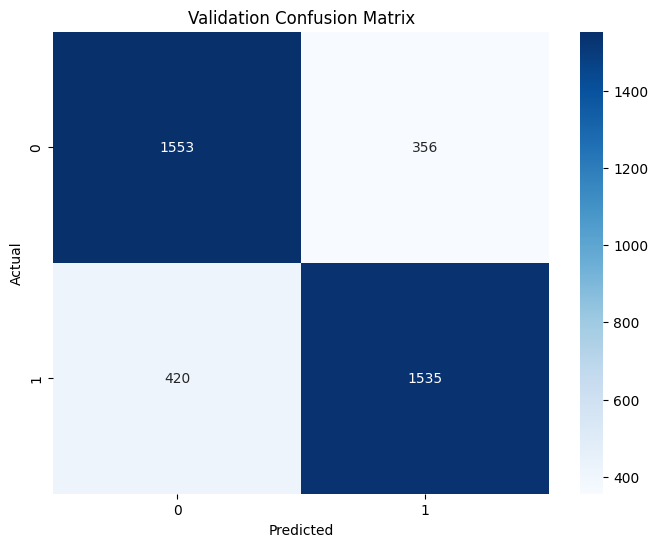

In [83]:
# Make predictions on the validation set
y_val_pred = model.predict(X1_val_balanced)

# Calculate accuracy
val_accuracy = accuracy_score(y1_val_balanced, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Generate confusion matrix
val_cm = confusion_matrix(y1_val_balanced, y_val_pred)

# Print classification report
print("Validation Classification Report:")
print(classification_report(y1_val_balanced, y_val_pred))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Looking at the oversampled Validation Classification Report the new model performed reasonably well to predict class 1. 
This will also be done for the non-oversampled validation set. Here it is important to ensure that the model has not been trained on the non-oversampled validation set. 
This has however not been possible due to the scope of the project. Thus some over fitting is expected but the general ability of the model to predict the minority class 1 will at least be tested.

Validation Accuracy (Non-Oversampled): 0.81
Validation Classification Report (Non-Oversampled):
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      1939
           1       0.12      0.85      0.21        61

    accuracy                           0.81      2000
   macro avg       0.56      0.83      0.55      2000
weighted avg       0.97      0.81      0.87      2000



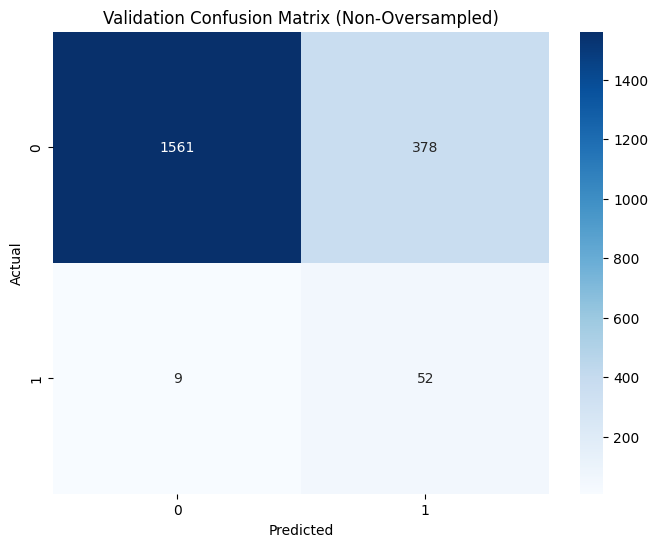

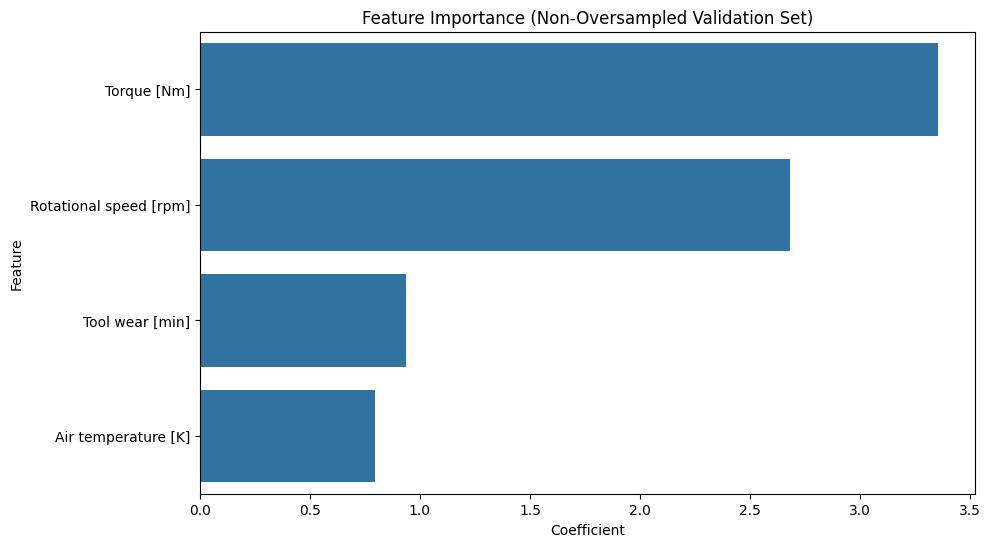

In [ ]:
# Remove 'Process temperature [K]' from the validation set
X_val_non_upsampled = X_val.drop(columns=['Process temperature [K]'])

# Scale the features
X_val_non_upsampled_scaled = scaler.transform(X_val_non_upsampled)


# Make predictions on the non-oversampled validation set
y_val_non_upsampled_pred = model.predict(X_val_non_upsampled_scaled)

# Calculate accuracy
val_non_upsampled_accuracy = accuracy_score(y_val, y_val_non_upsampled_pred)
print(f"Validation Accuracy (Non-Oversampled): {val_non_upsampled_accuracy:.2f}")

# Generate confusion matrix
val_non_upsampled_cm = confusion_matrix(y_val, y_val_non_upsampled_pred)

# Print classification report
print("Validation Classification Report (Non-Oversampled):")
print(classification_report(y_val, y_val_non_upsampled_pred))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(val_non_upsampled_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix (Non-Oversampled)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Visualize feature importance
coefficients = pd.DataFrame({'Feature': X_val_non_upsampled.columns, 'Coefficient': model.coef_[0]})
coefficients = coefficients.sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Feature Importance (Non-Oversampled Validation Set)')
plt.show()



# Conclusion for Logistic regression model # 

1. Model performance: 
- Looking at the Validation Classification Report (Non-Oversampled) the logistic regression model has an Accuracy of 85%
for class 1 the recall is much better than the first model and is thus more satisfactory even though the accuracy of the first model is better. 
This comes down to wanting to predict Failure (class 1) and not being sensitive to wrong predictions of class 0. It has however a low precision for class 1 at 0.12 compared to the oversampled validation set with a precision of 0.81
 

2. Feature importance:
- All features have a positive coefficient but Air temperature and Tool wear could be dropped out
 

3. Limitations: 
 - The data set is still relatively small
 - The data is not split into the different machine types (M, L, H).


4. Potential improvements: 
- Collet more data especially for class 1 
- Split the data set up into the 3 different machine types (M, L, H)
- Feature engineering or selection: try selecting even fewer features
- Cross-validation


# Random Forest #

Here Random forest is chosen over classification tree. RF is a better model for this task due to the data sheet being imbalanced. 

# Fine-tune model  # 

In [85]:
# Random forrest model will be don using Gini criterion
# Initialize the Random Forest Classifier with Gini criterion
rf_model = RandomForestClassifier(criterion='gini', random_state=42)

# Train the model using the training data
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

## Model Evaluation

Random Forest Model Accuracy: 0.984
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.89      0.60      0.72        68

    accuracy                           0.98      2000
   macro avg       0.94      0.80      0.86      2000
weighted avg       0.98      0.98      0.98      2000



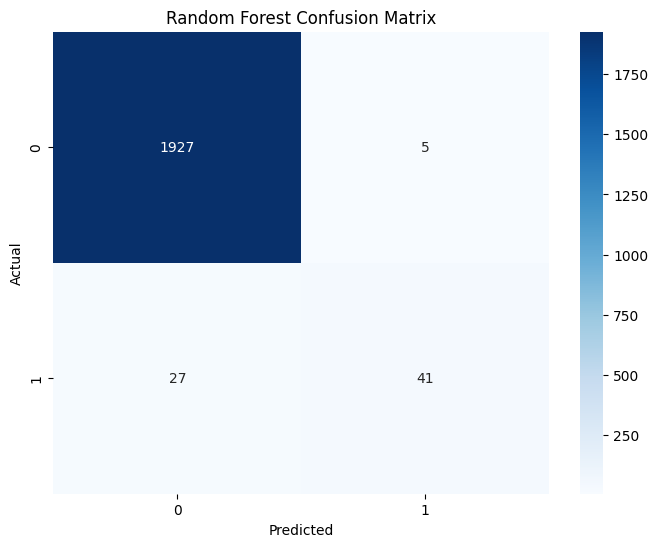

Feature Importances:
                   Feature  Importance
3              Torque [Nm]    0.306903
2   Rotational speed [rpm]    0.213247
4          Tool wear [min]    0.172663
0      Air temperature [K]    0.155462
1  Process temperature [K]    0.151725


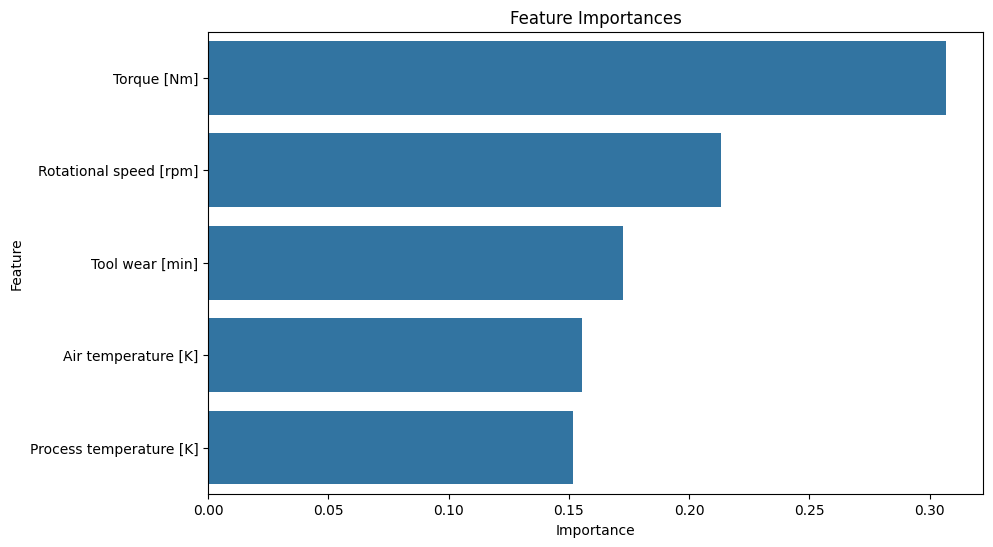

In [86]:
# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

# Display the evaluation metrics
print("Random Forest Model Accuracy:", accuracy_rf)
print("Random Forest Classification Report:\n", classification_rep_rf)

# Generate confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for visualization
features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances:")
print(features_df)

# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Feature Importances')
plt.show()

The model performance was okay on the training set. Due to the scope of the mini project, more iterations of the Random Forest model will not be done.

Next is to see it's performance on the validation set.

Random Forest Model Validation Accuracy: 0.984
Random Forest Validation Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1939
           1       0.82      0.61      0.70        61

    accuracy                           0.98      2000
   macro avg       0.90      0.80      0.84      2000
weighted avg       0.98      0.98      0.98      2000



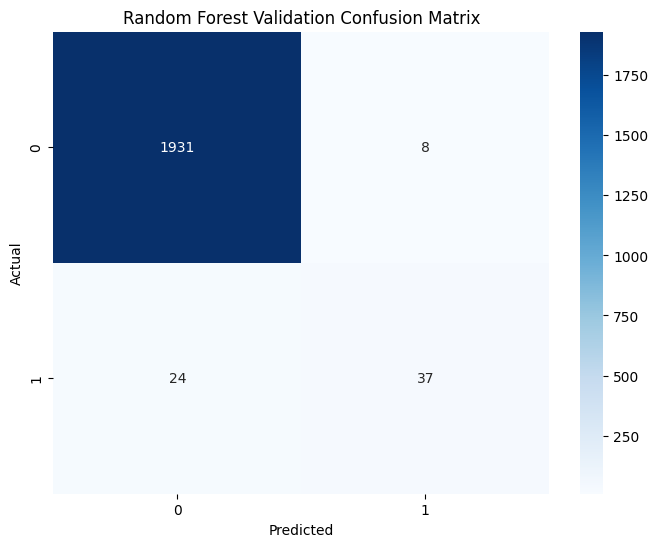

,Feature,Importance
3,Torque [Nm],0.306903
2,Rotational speed [rpm],0.213247
4,Tool wear [min],0.172663
0,Air temperature [K],0.155462
1,Process temperature [K],0.151725


In [87]:
# Evaluate the model using the validation set
# Make predictions
y_val_pred_rf = rf_model.predict(X_val)

# Evaluate the model
val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
classification_rep_rf = classification_report(y_val, y_val_pred_rf)

# Display the evaluation metrics
print("Random Forest Model Validation Accuracy:", val_accuracy_rf)
print("Random Forest Validation Classification Report:\n", classification_rep_rf)

# Generate confusion matrix
val_cm_rf = confusion_matrix(y_val, y_val_pred_rf)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(val_cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Validation Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Visualize feature importances
features_df

# Conclusion for random forest model #

1. Model performance: 
- Looking at the Validation Classification Report the Random forest model performs better than the Logistic regression model without oversampling when looking at validation accuracy of 98.4% The recall for the model is mediocre at 61% meaning 39% of failures are not classified. This is problematic given that over-predicting failure class 1 is better than under-predicting it


2. Feature importance
- All features have a positive coefficient


3. Limitations: 
 - The data set is small
 - The data is not split into the different machine types (M, L, H)

 
4. Potential improvements: 
- Collet more data
- Imbalanced data set: do up or down scaling
 